<a href="https://colab.research.google.com/github/farz-1/template/blob/master/CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/colab/

/content/drive/MyDrive/colab


In [ ]:
import json

with open('tad_data.json') as f:
    document = json.load(f)


In [ ]:
!head tad_data.json

[
  {
    "UID": "AVqkIhwDv8e3D1O-lebb",
    "Name": "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",
    "DoRecommend": "TRUE",
    "Rating": 5,
    "Review": "This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.",
    "Title": "Kindle",
    "Username": "Adapter"
  },


In [ ]:
document[0]['Review']

'This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.'

In [ ]:
def column(matrix, i):
    return [row[i] for row in matrix]
import random

data=random.choices(document,k=9200)

In [ ]:

data[0]

vals=[]
vals.clear()

for i in range(len(data)):
  if(data[i]['DoRecommend']=='TRUE'):
    data[i]['DoRecommend']=True
  else:
    data[i]['DoRecommend']=False
for i in range(len(data)):
    if(data[i]['DoRecommend']!=True and data[i]['DoRecommend']!=False):
        vals.append(i)
    if(len(data[i]['Review'])<5):
        vals.append(i)

print(len(data))

vals=sorted(vals,reverse=True)

for i in range(len(data)):
  if(data[i]['DoRecommend']==True):
    data[i]['DoRecommend']="TRUE"
  else:
    data[i]['DoRecommend']="FALSE"

print(len(data))
for g in vals:
  del data[g]
print(len(vals))
print(len(data))
print(type(data[0]['DoRecommend']))


9200
9200
5
9195
<class 'str'>


In [ ]:
from sklearn.model_selection import train_test_split

X= column(data,'DoRecommend')
Y= column(data,'Review')

rec_train_val,rec_test,rev_train_val,rev_test=train_test_split(X,Y,test_size=0.2, random_state=12)
rec_train,rec_val,rev_train,rev_val=train_test_split(rec_train_val,rev_train_val,test_size=0.25,random_state=12)
print(len(rec_train))
print(len(rec_val))
print(len(rec_test))

total=len(data)

5517
1839
1839


In [ ]:
len(rev_train)/total, len(rev_val)/total, len(rev_test)/total

(0.6, 0.2, 0.2)

In [ ]:
print(f"{len(rec_train)=}\t{len(rev_train)=}")
print(f"{len(rec_val)=}\t{len(rev_val)=}")
print(f"{len(rec_test)=}\t{len(rev_test)=}")

len(rec_train)=5517	len(rev_train)=5517
len(rec_val)=1839	len(rev_val)=1839
len(rec_test)=1839	len(rev_test)=1839


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import random
# Step 0: Vectorize text
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(rev_train)

# Step 1: Pick k random "centroids"
k = 4 # number of clusters
n_samples, n_features = tfidf.shape
centroids = np.zeros((k, n_features))
for i in range(k):
    centroid = tfidf[np.random.choice(n_samples)].toarray()
    centroids[i] = centroid

# Step 2: Assign each vector to its closest centroid
def assign_cluster(tfidf, centroids):
    cluster_assignments = []
    for i in range(tfidf.shape[0]):
        vector = tfidf[i].toarray()
        distances = np.linalg.norm(vector - centroids, axis=1)
        closest_centroid = np.argmin(distances)
        cluster_assignments.append(closest_centroid)
    return cluster_assignments

cluster_assignments = assign_cluster(tfidf, centroids)

# Step 3: Recalculate the centroids based on the closest vectors
def recalculate_centroids(tfidf, cluster_assignments, k):
    new_centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_mean = np.mean(tfidf[np.where(np.array(cluster_assignments) == i)].toarray(), axis=0)
        new_centroids[i] = cluster_mean
    return new_centroids

# Repeat Steps 2 and 3 until the model converges
max_iterations = 100
for iteration in range(max_iterations):
    cluster_assignments = assign_cluster(tfidf, centroids)
    new_centroids = recalculate_centroids(tfidf, cluster_assignments, k)
    if np.allclose(centroids, new_centroids):
        break
    centroids = new_centroids

# The model has now converged
print("Converged after", iteration + 1, "iterations.")



Converged after 37 iterations.


In [ ]:

print(len(centroids[0]))

6029


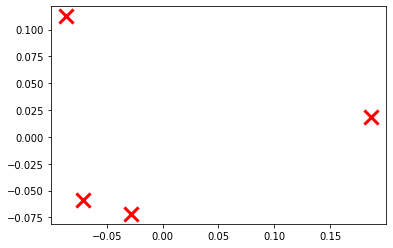

In [ ]:
import matplotlib.pyplot as plt

# Project the centroids to 2D 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids)

# Create a scatter plot of the centroids
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker='x', s=200, linewidths=3, color='r')

# Show the plot
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(rev_train, rec_train, test_size=0.2, random_state=12)

# Define the classifiers and their parameters
dummy_classifiers = [
    DummyClassifier(strategy="most_frequent"),
    DummyClassifier(strategy="stratified")
]
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
svc = SVC(kernel='rbf')

# Define the feature representations
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Evaluate the classifiers using cross-validation
for clf in dummy_classifiers + [logistic_regression, svc]:
    for vectorizer in [count_vectorizer, tfidf_vectorizer]:
        X_train_transformed = vectorizer.fit_transform(X_train)
        scores = cross_val_score(clf, X_train_transformed, y_train, cv=5)
        print(f"{clf.__class__.__name__} with {vectorizer.__class__.__name__}: {scores.mean():.3f} +/- {scores.std():.3f}")


DummyClassifier with CountVectorizer: 0.728 +/- 0.000
DummyClassifier with TfidfVectorizer: 0.728 +/- 0.000
DummyClassifier with CountVectorizer: 0.596 +/- 0.012
DummyClassifier with TfidfVectorizer: 0.598 +/- 0.010
LogisticRegression with CountVectorizer: 0.714 +/- 0.015
LogisticRegression with TfidfVectorizer: 0.733 +/- 0.005
SVC with CountVectorizer: 0.739 +/- 0.003
SVC with TfidfVectorizer: 0.774 +/- 0.006


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

# split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# define the pipeline with TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# define the parameter grid to search over
params = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__max_features': [1000, 5000, 10000, None],
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# evaluate the pipeline on the validation set
accuracy = pipeline.score(X_val, y_val)
print(f"Validation accuracy: {accuracy}")

# use the validation set to find the best parameters
best_params = {}
best_accuracy = 0
for sublinear_tf in [True, False]:
    for max_features in [1000, 5000, 10000, None]:
        for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
            pipeline.set_params(tfidf__sublinear_tf=sublinear_tf, tfidf__max_features=max_features, lr__C=C)
            pipeline.fit(X_train, y_train)
            accuracy = pipeline.score(X_val, y_val)
            if accuracy > best_accuracy:
                best_params = {'tfidf__sublinear_tf': sublinear_tf, 'tfidf__max_features': max_features, 'lr__C': C}
                best_accuracy = accuracy

print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy}")


Validation accuracy: 0.0


KeyboardInterrupt: ignored

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 116.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.8 MB/s eta 0:00:00


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ValueError: ignored